In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from jax import grad, jit, vmap
import mi
import sklearn.linear_model as linear_models
import copy

from tasks import ClippedPolynomialTask, IBTask


def get_norm(x):
    return np.sqrt((x**2).sum())


def get_degree(x, y, eps=1e-18):
    dp = x.dot(y)
    cos_v = dp / (get_norm(x) * get_norm(y) + eps)
    rad = np.arccos(np.clip(cos_v, -1, 1))
    degree = 180. * rad / np.pi
    return degree


def get_reg_err(H_, Y_):
    theta = jnp.linalg.inv(H_.T @ H_) @ H_.T @ Y_
    res = H_ @ theta - Y_
    err = res.T @ res
    return err[0, 0]


def g_H(H_, Y_):
    """Find the line regression gradient wrt H given H and Y."""
    I = np.eye(Y_.shape[0])

    ALPHA = np.linalg.inv(H_.T @ H_)
    BETA = H_ @ ALPHA @ H_.T

    Q = Y_.T @ H_ @ ALPHA
    P = -2 * (Y_.T @ (I - BETA) @ H_ @ ALPHA + Q)

    a = I - BETA
    b = 2 * BETA @ (I - BETA)

    second_term = b @ Y_ @ Q

    g = a @ Y_ @ P + second_term

    g_approx = a @ Y_ @ P

    info = {
        "a": a,
        "b": b,
        ####
        "ALPHA": ALPHA,
        "BETA": BETA,
        ####
        "P": P,
        "Q": Q,
        "second_term": second_term,
        "g": g,
        "g_approx": g_approx,
    }
    return g, info


def fAndG(H, Y):
    """
    For (H * inv(H' * H) * H' * Y - Y)' * (H * inv(H' * H) * H' * Y - Y)
    find the value and gradient of H and Y
    """
    assert isinstance(H, np.ndarray)
    dim = H.shape
    assert len(dim) == 2
    H_rows = dim[0]
    H_cols = dim[1]
    assert isinstance(Y, np.ndarray)
    dim = Y.shape
    assert len(dim) == 1
    Y_rows = dim[0]
    assert H_rows == Y_rows

    T_0 = np.linalg.inv((H.T).dot(H))
    t_1 = ((Y).dot(H)).dot(T_0)
    t_2 = ((t_1).dot(H.T) + -Y)
    t_3 = (H).dot((T_0).dot((H.T).dot(Y)))
    t_4 = (t_3 - Y)
    t_5 = ((t_2).dot(H)).dot(T_0)
    T_6 = np.outer(t_3, t_5)
    T_7 = np.outer((H).dot((T_0).dot((H.T).dot(t_4))), t_1)
    functionValue = (t_2).dot(t_4)
    gradient = ((((2 * np.outer(Y, t_5)) - (T_7 + T_6)) +
                 (2 * np.outer(t_4, t_1))) - (T_6 + T_7))

    return functionValue, gradient


def errorfill(x, y, yerr, color=None, alpha_fill=0.3, ax=None, label=None):
    ax = ax if ax is not None else plt.gca()
    if color is None:
        color = next(ax._get_lines.prop_cycler)['color']
    if np.isscalar(yerr) or len(yerr) == len(y):
        ymin = y - yerr
        ymax = y + yerr
    elif len(yerr) == 2:
        ymin, ymax = yerr
    ax.plot(x, y, color=color, label=label)
    ax.fill_between(x, ymax, ymin, color=color, alpha=alpha_fill)


In [2]:
def evolve_H_general(
    H,
    Y,
    W,
    feedback_f,
    feedback_param,
    t_max,
    mu,
    binsize,
    get_gh_norm=False,
    get_degrees=False,
):
    """Evolve H using the dynamics of FA.
    Args:
        H: (n, m)
        H: (n, 1)
        feedback_f: Callable. the function used to compute feedback signal
        feedback_param: tuple. a list of parameters used by feedback_f.
        mu: learning rate
        binsize: bin size used to calculate MI.
        get_gh_norm: bool. Return gh norm if true.
        get_degrees: bool. Return degress between 
            the fa signal and regression loss gradient wrt H if True.
    Returns:
        mse: MSE list between H * theta and Y with best theta.
        mse_d: MSE list between HW and Y
        i_hys: Mutual information between H and Y
    """
    vmin = -1
    vmax = 1
    n, m = H.shape

    I = np.eye(m)
    Hs = [H.copy()]

    fa_signal = feedback_f(H, Y, W, *feedback_param)
    i_hys = [mi.binned_mi(H, Y, binsize=binsize)]

    if get_gh_norm:
        gH_norms = [get_norm(g_H(H, Y)[1]['g'].reshape(-1))]
    else:
        gH_norms = []

    if get_degrees:
        degrees = [
            get_degree(fa_signal.reshape(-1),
                       g_H(H, Y)[1]['g'].reshape(-1))
        ]
    else:
        degrees = []

    for t in range(t_max):
        dH = -mu * feedback_f(H, Y, W, *feedback_param)
        H += dH
        Hs.append(H.copy())
        # I(H; Y)
        i_hys.append(mi.binned_mi(H, Y, binsize=binsize))

        if get_gh_norm:
            gH_norms.append(get_norm(g_H(H, Y)[1]['g'].reshape(-1)))
        if get_degrees:
            _, g_info = g_H(H, Y)
            degrees.append(
                get_degree(fa_signal.reshape(-1), g_info['g'].reshape(-1)))

    mse = []
    mse_d = []
    H_norms = []
    for _H in Hs:
        H_norms.append(np.sqrt((_H**2).sum(axis=1)).mean())
        optimal_w = np.linalg.inv((_H.T @ _H)) @ _H.T @ Y
        err = _H @ optimal_w - Y
        mse.append(np.mean(err**2))

        err_d = _H @ W - Y
        mse_d.append(np.mean(err_d**2))

    mse = np.array(mse)
    mse_d = np.array(mse_d)
    i_hys = np.array(i_hys)
    gH_norms = np.array(gH_norms)
    H_norms = np.array(H_norms)
    degrees = np.array(degrees)
    return mse, mse_d, i_hys, H_norms, gH_norms, degrees


def evolve_H_FA(
    H,
    Y,
    W,
    t_max,
    mu=5e-1,
    binsize=1 / 30,
    get_gh_norm=False,
    get_degrees=False,
):
    _m = H.shape[1]

    def feedback_f(_H, _Y, _W, _B):
        fbs = (_H @ _W - _Y) @ _B
        return fbs

    feedback_param = (np.random.normal(0, 1, (1, _m)), )
    return evolve_H_general(
        H,
        Y,
        W,
        feedback_f,
        feedback_param,
        t_max,
        mu=mu,
        binsize=binsize,
        get_gh_norm=get_gh_norm,
        get_degrees=get_degrees,
    )


def evolve_H_TF(
    H,
    Y,
    W,
    t_max,
    mu=5e-1,
    binsize=1 / 30,
    get_gh_norm=False,
    get_degrees=False,
):
    _m = H.shape[1]

    def feedback_f(_H, _Y, _W, _B):
        fbs = -1 - _Y @ _B
        return fbs

    feedback_param = (np.random.normal(0, 1, (1, m)), )
    return evolve_H_general(
        H,
        Y,
        W,
        feedback_f,
        feedback_param,
        t_max,
        mu=mu,
        binsize=binsize,
        get_gh_norm=get_gh_norm,
        get_degrees=get_degrees,
    )


def evolve_H_NF(
    H,
    Y,
    W,
    t_max,
    mu=5e-1,
    binsize=1 / 30,
    get_gh_norm=False,
    get_degrees=False,
):
    """Network Feedback"""
    _m = H.shape[1]

    def feedback_f(_H, _Y, _W, _B1, _B2):

        fbs = -1 - np.tanh(_Y @ _B1) @ _B2
        return fbs

    n_hb = 4
    feedback_param = (
        np.random.normal(0, 1, (1, n_hb)),
        np.random.normal(0, 1, (n_hb, _m)),
    )
    return evolve_H_general(
        H,
        Y,
        W,
        feedback_f,
        feedback_param,
        t_max,
        mu=mu,
        binsize=binsize,
        get_gh_norm=get_gh_norm,
        get_degrees=get_degrees,
    )


def evolve_H_NFA(
    H,
    Y,
    W,
    t_max,
    mu=5e-1,
    binsize=1 / 30,
    get_gh_norm=False,
    get_degrees=False,
):
    """Network Feedback"""
    _m = H.shape[1]

    def feedback_f(_H, _Y, _W, _B, amp=0.1):
        fbs = (_H @ _W - _Y) @ (_B + amp * np.random.normal(0, 1, _B.shape))
        return fbs

    n_hb = 4
    feedback_param = (np.random.normal(0, 1, (1, _m)), )
    return evolve_H_general(
        H,
        Y,
        W,
        feedback_f,
        feedback_param,
        t_max,
        mu=mu,
        binsize=binsize,
        get_gh_norm=get_gh_norm,
        get_degrees=get_degrees,
    )


## FA dynamics

In [14]:
repeat_num = 10
t_max = 20
binsize = 1 / 10
n = 1000
m = 6
H = np.random.rand(n, m) - 0.5
Y = np.random.rand(n, 1) - 0.5
H = H.astype(float)
Y = Y.astype(float)

print(mi.binned_mi(H, Y, binsize=binsize))
W = (1. / m) * np.random.normal(0, 1, (m, 1))

mses = []
mse_ds = []
I_HYss = []
H_normss = []
gH_normss = []
degreess = []
for _i in range(repeat_num):
    mse, mse_d, I_HYs, H_norms, gH_norms, degrees = evolve_H_FA(copy.deepcopy(H),
                                       copy.deepcopy(Y),
                                       copy.deepcopy(W),
                                       t_max,
                                       mu=2e-1,
                                       binsize=binsize,
                                       get_gh_norm=True,
                                       get_degrees=True)
    mses.append(mse.reshape(1, -1))
    mse_ds.append(mse_d.reshape(1, -1))
    I_HYss.append(I_HYs.reshape(1, -1))
    H_normss.append(H_norms.reshape(1, -1))
    gH_normss.append(gH_norms.reshape(1, -1))
    degreess.append(degrees.reshape(1, -1))

mses = np.concatenate(mses, axis=0)
mse_ds = np.concatenate(mse_ds, axis=0)
H_normss = np.concatenate(H_normss, axis=0)
I_HYss = np.concatenate(I_HYss, axis=0)
gH_normss = np.concatenate(gH_normss, axis=0)
degreess = np.concatenate(degreess, axis=0)



3.3141469921694444


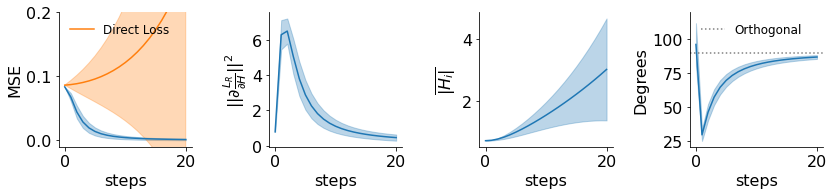

In [15]:
x = np.arange(mses.shape[1])
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(1, 4, figsize=[12, 3], sharex=True)
errorfill(
    x,
    mses.mean(axis=0),
    mses.std(axis=0),
    color=None,
    alpha_fill=0.3,
    ax=axes[0],
)
errorfill(
    x,
    mse_ds.mean(axis=0),
    mse_ds.std(axis=0),
    color=None,
    alpha_fill=0.3,
    ax=axes[0],
    label="Direct Loss",
)
axes[0].legend(loc=2, prop={'size': 12}, frameon=False)
axes[0].set_ylabel("MSE")
axes[0].set_ylim(-0.01, 0.2)

errorfill(
    x,
    gH_normss.mean(axis=0),
    gH_normss.std(axis=0),
    color=None,
    alpha_fill=0.3,
    ax=axes[1],
)
axes[1].set_ylabel(r"$||\partial \frac{L_R}{\partial H} ||^2$")

errorfill(
    x,
    H_normss.mean(axis=0),
    H_normss.std(axis=0),
    color=None,
    alpha_fill=0.3,
    ax=axes[2],
)
axes[2].set_ylabel(r"$\overline{|H_i|}$")

axes[3].axhline(y=90, ls=':', c='grey', label='Orthogonal')  #, lw=1)
errorfill(
    x,
    degreess.mean(axis=0),
    degreess.std(axis=0),
    color=None,
    alpha_fill=0.3,
    ax=axes[3],
)

axes[3].set_ylabel("Degrees")
axes[3].set_ylim(degreess.mean(axis=0).min() * 0.7, 120)
for ax in axes.flat:
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.set_xlabel("steps")

axes[3].legend(loc=2, prop={'size': 12}, frameon=False)

plt.tight_layout()
plt.savefig('figs/fig.2.theory.png')
plt.show()

## Different variants of FA

In [9]:
repeat_num = 10
t_max = 20
binsize = 1 / 10
n = 20000
m = 6

H = np.random.rand(n, m) - 0.5
Y = np.random.rand(n, 1) - 0.5
H = H.astype(float)
Y = Y.astype(float)

print(mi.binned_mi(H, Y, binsize=binsize))
W = (1. / m) * np.random.normal(0, 1, (m, 1))

evolve_funcs = {
    "FA": evolve_H_FA,
    "TF": evolve_H_TF,
    "NF": evolve_H_NF,
    "NFA": evolve_H_NFA,
}
res = {}
for name, ev_func in evolve_funcs.items():
    mses = []
    mse_ds = []
    I_HYss = []
    for _i in range(repeat_num):
        mse, mse_d, I_HYs, _, _, _ = ev_func(
            copy.deepcopy(H),
            copy.deepcopy(Y),
            copy.deepcopy(W),
            t_max,
            mu=2e-1,
            binsize=binsize,
        )
        mses.append(mse.reshape(1, -1))
        mse_ds.append(mse_d.reshape(1, -1))
        I_HYss.append(I_HYs.reshape(1, -1))

    res[name] = {
        "mses": np.concatenate(mses, axis=0),
        "mse_ds": np.concatenate(mse_ds, axis=0),
        "I_HYss": np.concatenate(I_HYss, axis=0),
    }

3.303704634891119


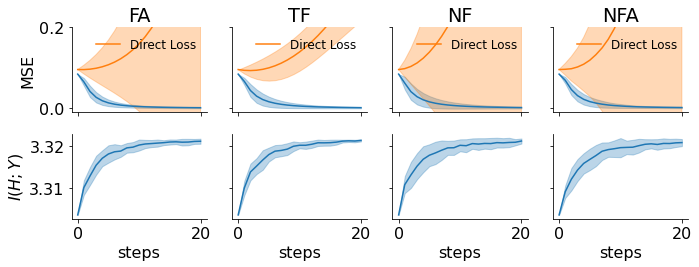

In [16]:
x = np.arange(t_max + 1)
nf = len(evolve_funcs)
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(2,
                         nf,
                         figsize=[2.5 * nf, 4],
                         sharex=True,
                         sharey='row')
axes[0, 0].set_ylim(-0.01, 0.2)
axes[0, 0].set_ylabel("MSE")
axes[1, 0].set_ylabel("$I(H;Y)$")
for idx, (name, res_single) in enumerate(res.items()):
    _mses = res_single['mses']
    _mse_ds = res_single['mse_ds']
    _I_HYss = res_single['I_HYss']

    axes[0, idx].set_title(name)
    errorfill(
        x,
        _mses.mean(axis=0),
        _mses.std(axis=0),
        color=None,
        alpha_fill=0.3,
        ax=axes[0, idx],
    )

    errorfill(
        x,
        _mse_ds.mean(axis=0),
        _mse_ds.std(axis=0),
        color=None,
        alpha_fill=0.3,
        ax=axes[0, idx],
        label="Direct Loss",
    )
    axes[0, idx].legend(loc='upper right', frameon=False, prop={'size': 12})

    errorfill(
        x,
        _I_HYss.mean(axis=0),
        _I_HYss.std(axis=0),
        color=None,
        alpha_fill=0.3,
        ax=axes[1, idx],
    )

    axes[-1, idx].set_xlabel("steps")

for ax in axes.flat:
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)

plt.tight_layout()
plt.savefig('figs/fig.4.theory_MI.png')
plt.show()